In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kstest, anderson


#Grab data and put numerical vals in one table
#################################################################################################################
dataset_as_given = pd.read_csv(r"d:\Desktop\Practice Python\21.gym_members_exercise_tracking.csv")
#print(dataset_as_given)

# Get column names
column_names = dataset_as_given.columns
#print(column_names)

desired = ["Age", "Weight (kg)", "Height (m)", "Max_BPM", "Avg_BPM", "Resting_BPM", 
           "Session_Duration (hours)", "Calories_Burned", "Fat_Percentage", "Water_Intake (liters)", "Workout_Frequency (days/week)", "Experience_Level", "BMI"]

dataset_as_given_numeric = dataset_as_given[desired]



#Get Rid of Outliers
#################################################################################################################

# Copy the dataset so you keep the original intact
cleaned_df = dataset_as_given.copy()

# Select numeric columns
numeric_cols = cleaned_df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    Q1 = cleaned_df[col].quantile(0.25)
    Q3 = cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]



print("Original rows:", dataset_as_given.shape[0])
print("Cleaned rows:", cleaned_df.shape[0])
print("Rows removed:", dataset_as_given.shape[0] - cleaned_df.shape[0])


#################################################################################################################

encoded_df = cleaned_df.copy()

encoded_df['Gender'] = encoded_df['Gender'].map({
    'Male': 1,
    'Female': 0
})

workout_dummies = pd.get_dummies(encoded_df['Workout_Type'], prefix='Workout', drop_first=True)
encoded_df = pd.concat([encoded_df.drop(columns=['Workout_Type']), workout_dummies], axis=1)




Original rows: 973
Cleaned rows: 931
Rows removed: 42


In [2]:
# ============================
#  MACHINE LEARNING PIPELINE
#  Predicting Gender
# ============================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# ---------------------------------------
# 1. Define features (X) and target (y)
# ---------------------------------------
X = encoded_df.drop(columns=['Gender'])
y = encoded_df['Gender']

# ---------------------------------------
# 2. Train/Test Split
# ---------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------------------
# 3. Scale numeric features
# ---------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------------------
# 4. Train a Random Forest Classifier
# ---------------------------------------
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# ---------------------------------------
# 5. Predictions & Evaluation
# ---------------------------------------
y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---------------------------------------
# 6. Feature Importance
# ---------------------------------------
importance = pd.Series(model.feature_importances_, index=X.columns)
importance = importance.sort_values(ascending=False)

print("\nFeature Importance:\n")
print(importance)


Accuracy: 0.983957219251337

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98        94
           1       0.98      0.99      0.98        93

    accuracy                           0.98       187
   macro avg       0.98      0.98      0.98       187
weighted avg       0.98      0.98      0.98       187


Feature Importance:

Water_Intake (liters)            0.347296
Weight (kg)                      0.190663
Height (m)                       0.157448
Fat_Percentage                   0.143389
BMI                              0.041594
Session_Duration (hours)         0.026344
Calories_Burned                  0.017534
Experience_Level                 0.015176
Avg_BPM                          0.014048
Max_BPM                          0.012145
Resting_BPM                      0.011410
Age                              0.009764
Workout_Frequency (days/week)    0.006064
Workout_Strength                 0.002882
Workout_Yo

Accuracy: 0.9840

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        94
           1       0.98      0.99      0.98        93

    accuracy                           0.98       187
   macro avg       0.98      0.98      0.98       187
weighted avg       0.98      0.98      0.98       187



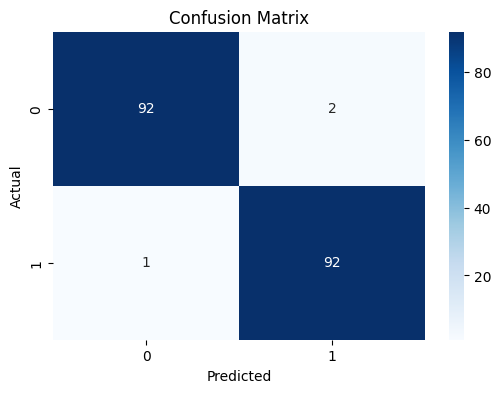

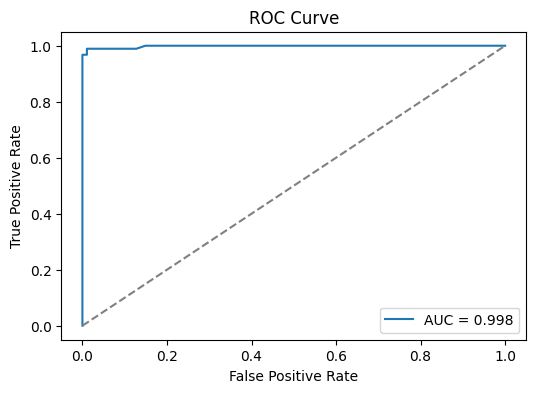

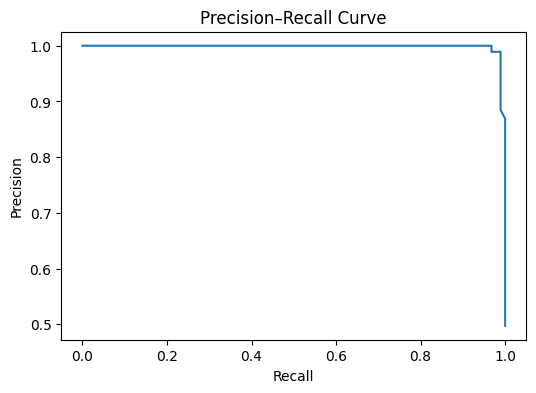


Permutation Importance (higher = more important):
Water_Intake (liters)            0.208556
Weight (kg)                      0.183422
Height (m)                       0.117112
Fat_Percentage                   0.096257
Experience_Level                 0.003209
Calories_Burned                  0.003209
Workout_Yoga                     0.001604
Avg_BPM                          0.000535
Workout_Frequency (days/week)    0.000000
Workout_HIIT                     0.000000
Workout_Strength                 0.000000
Session_Duration (hours)        -0.000535
Resting_BPM                     -0.000535
Max_BPM                         -0.000535
Age                             -0.000535
BMI                             -0.003209
dtype: float64


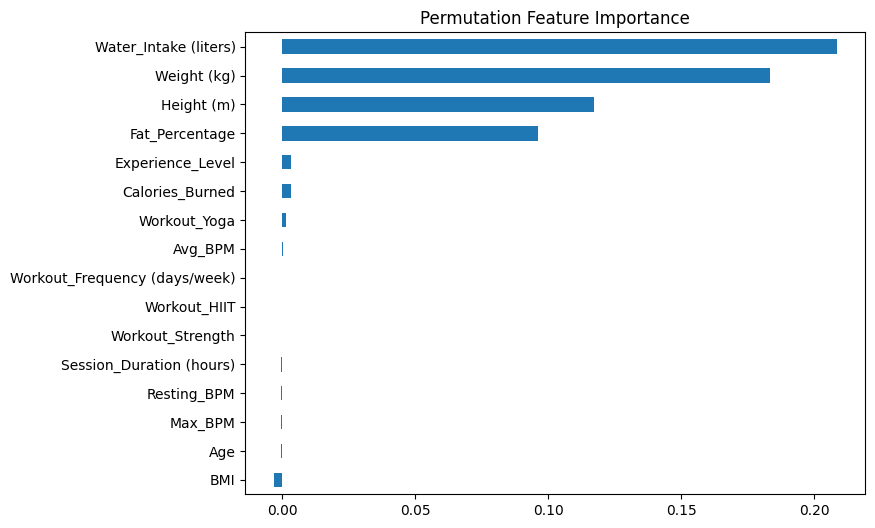

In [6]:
# ============================================================
#   MODEL EVALUATION — Understanding Model Accuracy
#   This cell evaluates your classifier using multiple metrics
#   Each section includes comments explaining what to look for
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
from sklearn.inspection import permutation_importance

# ------------------------------------------------------------
# 1. BASIC ACCURACY
# ------------------------------------------------------------
# Accuracy = proportion of correct predictions.
# Good for balanced datasets. If classes are imbalanced,
# accuracy can be misleading.
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


# ------------------------------------------------------------
# 2. CLASSIFICATION REPORT
# ------------------------------------------------------------
# Shows precision, recall, and F1-score for each class.
# Precision = how many predicted positives were correct.
# Recall = how many actual positives were found.
# F1 = balance between precision and recall.
# Look for balanced precision/recall across both genders.
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# ------------------------------------------------------------
# 3. CONFUSION MATRIX
# ------------------------------------------------------------
# Shows EXACTLY where the model is making mistakes.
# True Positives, True Negatives, False Positives, False Negatives.
# Look for strong diagonal values (correct predictions).
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ------------------------------------------------------------
# 4. ROC CURVE + AUC SCORE
# ------------------------------------------------------------
# ROC curve shows how well the model separates the two classes.
# AUC = Area Under Curve.
# AUC close to 1.0 = excellent separation.
# AUC around 0.5 = random guessing.
y_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# ------------------------------------------------------------
# 5. PRECISION–RECALL CURVE
# ------------------------------------------------------------
# Useful if one class is underrepresented.
# Shows the tradeoff between precision and recall.
# Look for curves that stay high (good precision) and far right (good recall).
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


# ------------------------------------------------------------
# 6. PERMUTATION IMPORTANCE
# ------------------------------------------------------------
# Measures how much each feature contributes to the model.
# If shuffling a feature drops accuracy a lot → important feature.
# Helps you understand what drives gender prediction.
perm = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)

importance_df = (
    pd.Series(perm.importances_mean, index=X.columns)
    .sort_values(ascending=False)
)

print("\nPermutation Importance (higher = more important):")
print(importance_df)

plt.figure(figsize=(8,6))
importance_df.plot(kind='barh')
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()
plt.show()
